# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [439]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures



import warnings
warnings.filterwarnings('ignore')

In [474]:
cars = pd.read_csv(filepath_or_buffer='./Data/vehicles.csv')
print(cars.info())
print(cars.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

#### Business Details and Activity Details


**Business Context:** In this context, our focus revolves around used car data, encompassing the sale of pre-owned vehicles categorized by various attributes, including type, drive, cylinders, year, transmission, and other relevant categories.

**Objective of the Activity:** The primary objective of this endeavor is to discern the key factors influencing car prices. The dataset at our disposal comprises 426,880 rows and 17 features. The approach to price prediction involves leveraging one of the many available regression models in machine learning. The choice of the regression model hinges on its accuracy in prediction, gauged through metrics such as mean squared error.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Basic Data Cleansing by eliminating id column and duplicates

We've determined that the ID column in the dataset doesn't contribute to our use case, so we're opting to remove it.

Additionally, there are approximately 56,202 duplicate rows in the data, as evidenced below. It is crucial to eliminate this duplicate data to ensure the accuracy of our predictive model.

In [475]:
print("Number of rows in original dataset: ", len(cars))
cars.drop('id', inplace=True, axis=1)
print("Number of duplicates:", len(cars[cars.duplicated()]))
cars = cars.drop_duplicates()
print("Number of rows remaining after removing duplicates", len(cars))

Number of rows in original dataset:  426880
Number of duplicates: 56202
Number of rows remaining after removing duplicates 370678


**Categorical Columns**

The following are the categorical columns of interest within the dataset, along with their respective unique values.

In [476]:
categorical_columns = list(cars.select_dtypes(include=['object']).columns)
categorical_columns.remove('region') # Not interested in this because there are lot of values and graphing these wouldn't be useful.
categorical_columns.remove('state') # all states are present. So not useful for now. 
for column in categorical_columns:
    unique_values = cars[column].unique()
    print(f"Unique values in {column}:\n{unique_values}")
    print('\n')

Unique values in manufacturer:
[nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'ferrari' 'mini' 'pontiac' 'fiat' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan']


Unique values in model:
[nan 'sierra 1500 crew cab slt' 'silverado 1500' ... 'gand wagoneer'
 '96 Suburban' 'Paige Glenbrook Touring']


Unique values in condition:
[nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']


Unique values in cylinders:
[nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']


Unique values in fuel:
[nan 'gas' 'other' 'diesel' 'hybrid' 'electric']


Unique values in title_status:
[nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']


Unique values 

**More plots to understand data**

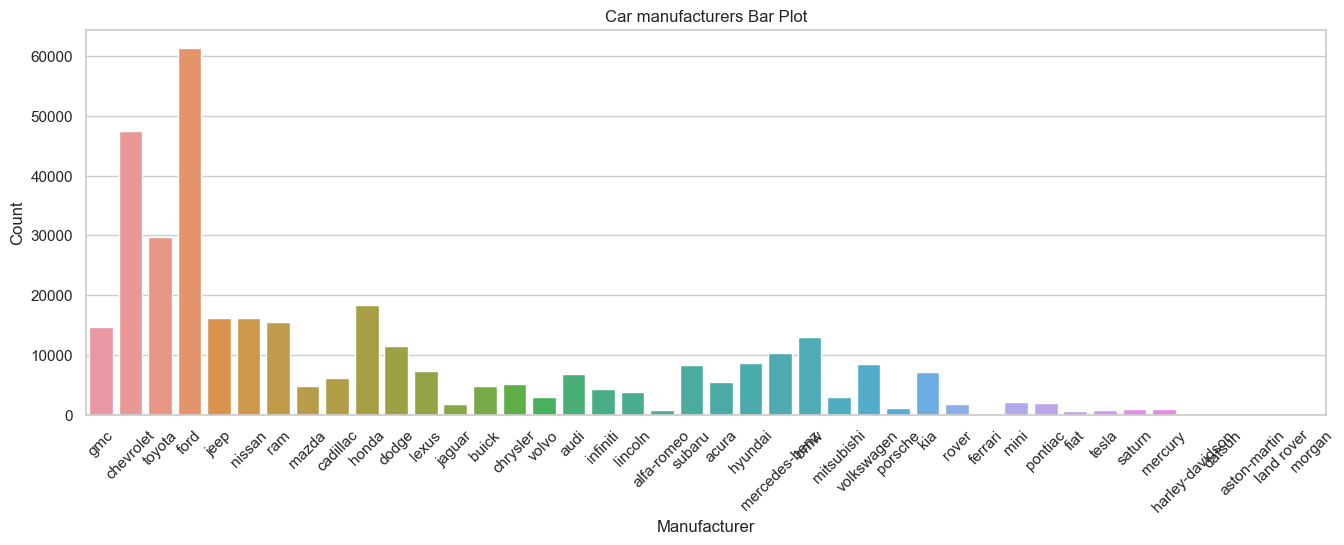

In [477]:
plt.figure(figsize=(16, 5))  # Adjust the width and height as needed
sns.countplot(data=cars, x='manufacturer').set(title='Car manufacturers Bar Plot')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

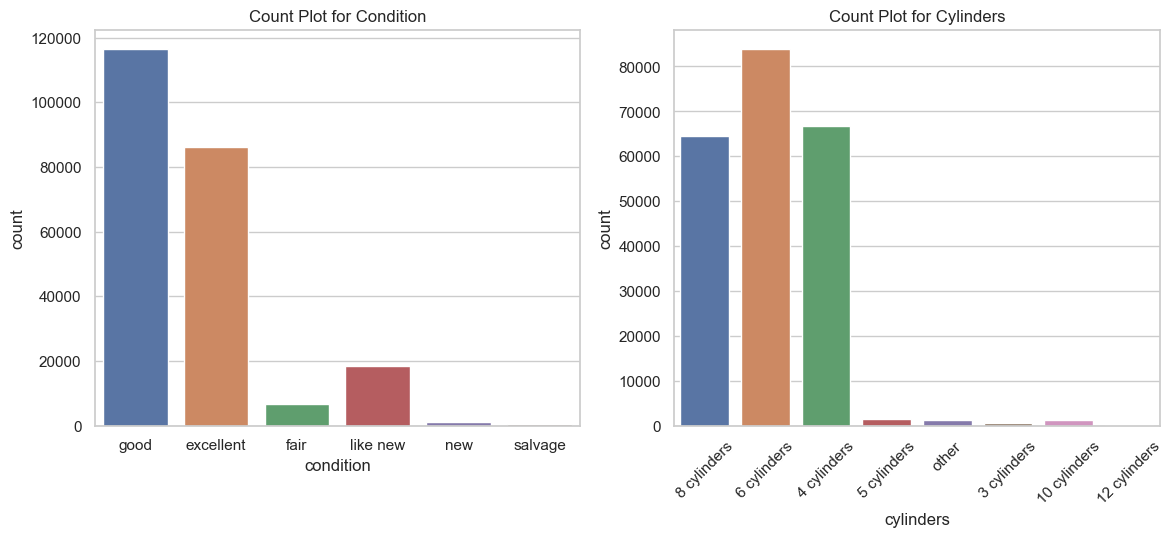

In [478]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='condition', data=cars, ax=axes[0])
axes[0].set_title('Count Plot for Condition')
sns.countplot(x='cylinders', data=cars, ax=axes[1])
axes[1].set_title('Count Plot for Cylinders')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

The above graph shows the dataset has a lot of used cars compared to new or salvage cars. Since the objective is to find used car prices, new and salvage cars data could be filtered out.

<Figure size 1600x1000 with 0 Axes>

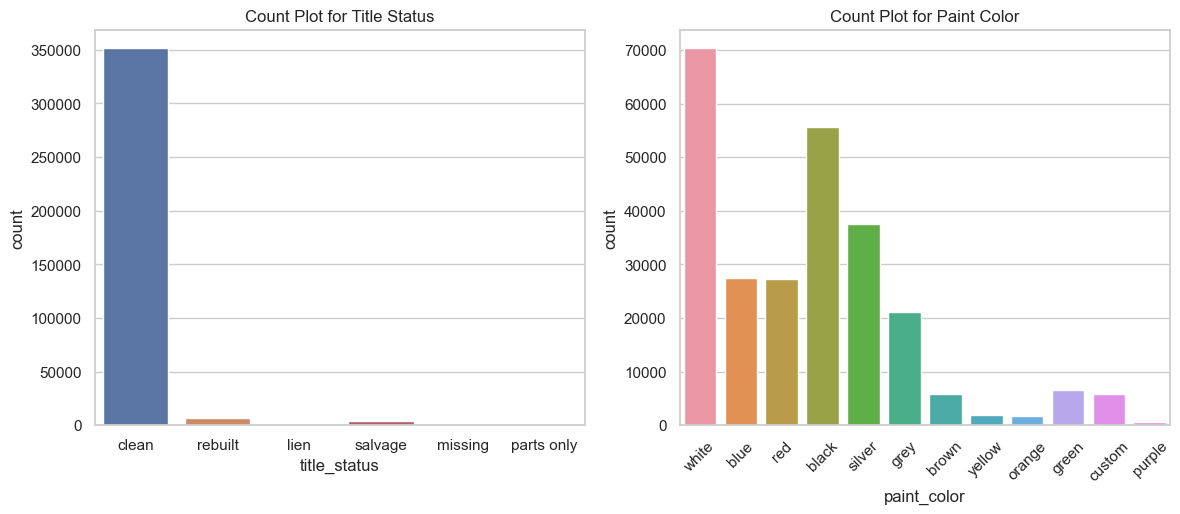

In [479]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='title_status', data=cars, ax=axes[0])
axes[0].set_title('Count Plot for Title Status')
sns.countplot(x='paint_color', data=cars, ax=axes[1])
axes[1].set_title('Count Plot for Paint Color')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

fuel
diesel       25930
electric      1595
gas         307783
hybrid        4684
other        28218
dtype: int64


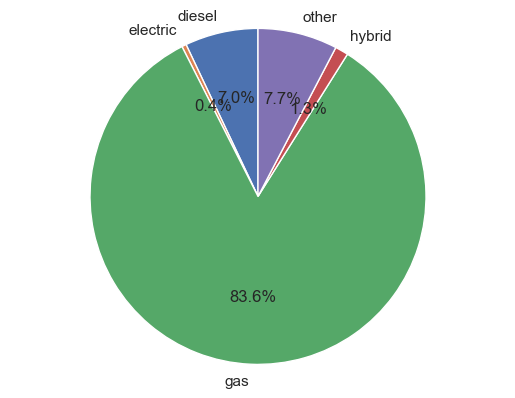

['diesel', 'electric', 'gas', 'hybrid', 'other']


In [480]:
data = cars.groupby('fuel').size()
print(data)
labels=['diesel','electric', 'gas', 'hybrid', 'other']
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()
print(labels)

The data shows that majority of the cars are gas fueled. with this data, predictions of car prices of electric, diesel and hybrid is not going to be accurate because the model will be biased towards gas.

In [481]:
unique_categories = cars['drive'].unique()
fig = px.pie(cars.dropna(), names='drive', title='Pie Chart of Unique drive')
fig.update_layout(
    legend_title_text='Drive',
    legend_traceorder='reversed',
    legend=dict(title=dict(text='Categories'))
)
fig.show()

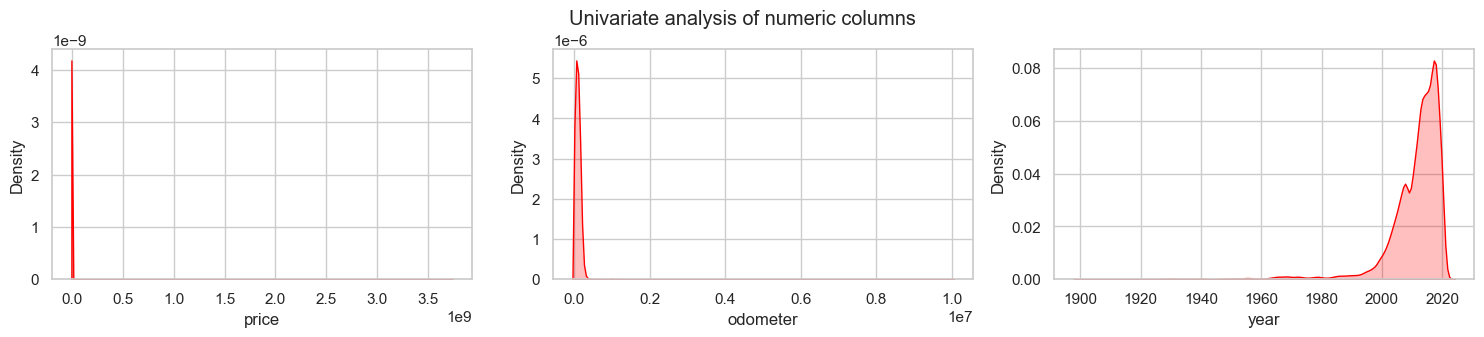

In [482]:
# Univariate analysis of numeric columns
numericCols = ['price', 'odometer', 'year']
plt.figure(figsize=(15, 15))
plt.suptitle("Univariate analysis of numeric columns")
for col in range(len(numericCols)):
    plt.subplot(5,3,col+1)
    sns.kdeplot(x = cars[numericCols[col]], shade=True, color='red')
    plt.xlabel(numericCols[col])
    plt.tight_layout()


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

**VIN number of a vehicle doesn't help predict the price of the car. Hence, we can get rid of the vin column.**

In [483]:
cars.drop('VIN', inplace = True, axis=1)

#### Outlier determination and elimination

Text(0, 0.5, 'Frequency')

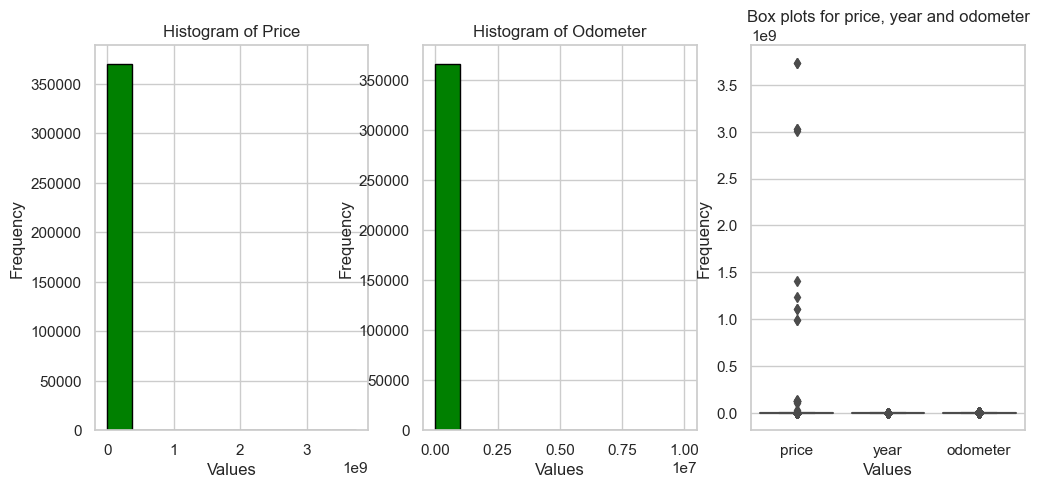

In [484]:
# Graphically identifying Outliers.

carsOriginal = cars # Just assigning to a new variable so that cleaned data doesn't affect these graphs later on.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
carsOriginal['price'].hist(ax=axes[0], bins=10, edgecolor='black', color='green')
axes[0].set_title('Histogram of Price')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
carsOriginal['odometer'].hist(ax=axes[1], bins=10, edgecolor='black', color='green')
axes[1].set_title('Histogram of Odometer')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')
sns.boxplot(data=cars, ax=axes[2])
axes[2].set_title('Box plots for price, year and odometer')
axes[2].set_xlabel('Values')
axes[2].set_ylabel('Frequency')

The histograms unmistakably reveal a notable presence of outliers in both the price and odometer columns. Given that these are the sole non-categorical features of interest, our focus is solely on identifying and eliminating outliers within these two columns. The subsequent step involves the removal of outliers specifically from the price and odometer features.

In [485]:
def eliminateoutliers(col, dataset):
    df=dataset[[col]]
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Calculate the IQR for each column
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers using IQR for each column
    outliers_iqr = ((df < lower_bound) | (df > upper_bound)).any(axis=1)
    return dataset[~outliers_iqr]

In [486]:
print("Total cars before outlier removal:", len(cars))
cars = eliminateoutliers('price', cars)
print("Total cars after removing price outliers", len(cars))
cars = eliminateoutliers('odometer', cars)
print("Total cars after removing odometer outliers", len(cars))

Total cars before outlier removal: 370678
Total cars after removing price outliers 363843
Total cars after removing odometer outliers 360155


<Axes: >

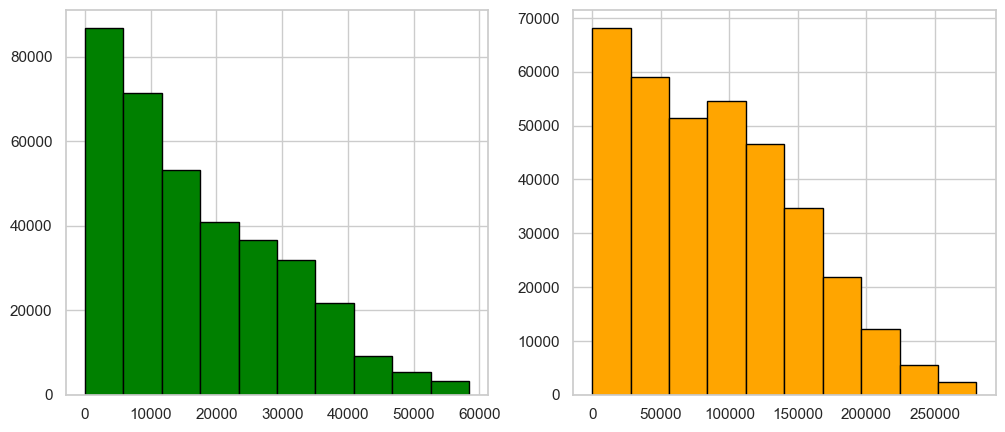

In [487]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
cars['price'].hist(ax=axes[0], bins=10, edgecolor='black', color='green')
cars['odometer'].hist(ax=axes[1], bins=10, edgecolor='black', color='orange')

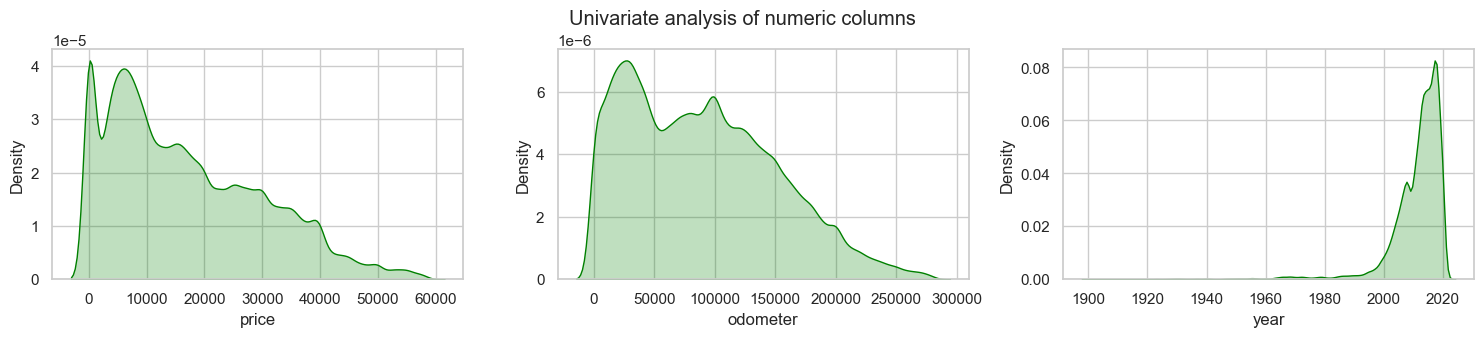

In [488]:
numericCols = ['price', 'odometer', 'year']
plt.figure(figsize=(15, 15))
plt.suptitle("Univariate analysis of numeric columns")
for col in range(len(numericCols)):
    plt.subplot(5,3,col+1)
    sns.kdeplot(x = cars[numericCols[col]], shade=True, color='green')
    plt.xlabel(numericCols[col])
    plt.tight_layout()

#### Observations Post Outlier Removal
Upon the removal of outliers from the dataset, notable changes are observed in the histograms of price and odometers. The Kernel Density Estimation (KDE) plots indicate a more balanced distribution compared to the initial dataset. However, it's essential to acknowledge that the "year" data still exhibits a rightward skew. Consequently, it's anticipated that the prediction accuracy for older car models may be comparatively less precise after model training.

***

### Handling Null Values
#### Observations and Potential Steps for Null Values

The table below provides an overview of the null values present in the data. Some features exhibit a substantial number of null values, while others have only a few. There are two primary approaches to address these null values:

1. **Complete Elimination:** Removing entries with null values entirely, with the assumption that it won't significantly impact our modeling.
2. **Imputation:** Filling null values with appropriate data using various techniques and libraries. This approach aims to retain valuable information from the dataset while addressing missing values

In [489]:
cars.isnull().sum()

region               0
price                0
year               828
manufacturer     13662
model             4249
condition       135662
cylinders       146059
fuel              2424
odometer          3413
title_status      6604
transmission      2004
drive           109407
size            257016
type             75788
paint_color     105384
state                0
dtype: int64

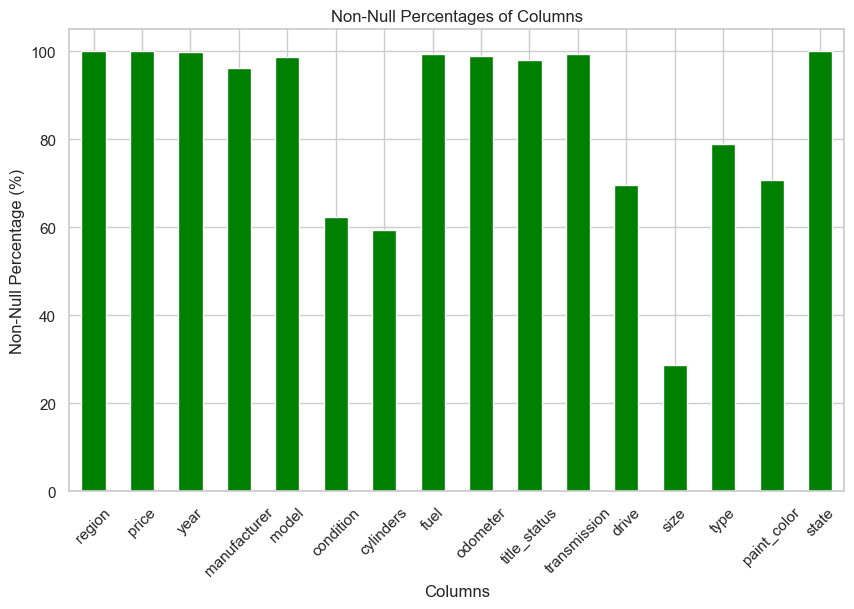

In [490]:
# Calculate the percentage of non-null values for each column
null_percentages = (1-cars.isnull().mean()) * 100

# Create a bar chart for non-null percentages
null_percentages.plot(kind='bar', rot=0, figsize=(10, 6), color='green')
plt.title('Non-Null Percentages of Columns')
plt.xlabel('Columns')
plt.ylabel('Non-Null Percentage (%)')
plt.xticks(rotation=45)
plt.show()

1. As observed above, columns with very few null values are being dropped from the dataset.
2. In the case of columns with a substantial number of nulls, the approach is to replace these null values with the most frequently occurring value in each respective column.

A column with over 70% of null values is unlikely to contribute meaningfully to price determination. Consequently, the decision is to eliminate the "size" column from the dataset.

In [491]:
cars.drop('size', inplace=True, axis=1)

In [492]:

print("Before Deleting any nulls: ", len(cars))
specific_column = 'year'
cars = cars.dropna(subset=[specific_column])
print("After deleting null year rows: ", len(cars))
specific_column = 'transmission'
cars = cars.dropna(subset=[specific_column])
print("After deleting null transmission rows: ", len(cars))
specific_column = 'fuel'
cars = cars.dropna(subset=[specific_column])
print("After deleting null fuel rows: ", len(cars))
specific_column = 'model'
cars = cars.dropna(subset=[specific_column])
print("After deleting null model rows: ", len(cars))

Before Deleting any nulls:  360155
After deleting null year rows:  359327
After deleting null transmission rows:  357380
After deleting null fuel rows:  355724
After deleting null model rows:  351547


In [493]:
# for Odometer, we can take mean of odometer values to fill in the null value.
cars['odometer'].fillna(math.ceil(np.mean(cars['odometer'])), inplace=True)

In [494]:
cars['condition'].fillna("good", inplace=True)
cars['manufacturer'].fillna('ford', inplace=True)
cars['cylinders'].fillna('6 cylinders', inplace=True)
cars['fuel'].fillna('gas', inplace=True)
cars['title_status'].fillna('clean', inplace=True)
cars['drive'].fillna('4wd', inplace=True)
cars['type'].fillna('sedan', inplace=True)
cars['paint_color'].fillna('white', inplace=True)


In [495]:
# cars.dropna(inplace=True)
cars.isnull().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

#### Observation on Null Handling:
Upon the completion of null value handling procedures, as indicated above, the dataset no longer contains any null values. Additionally, the imputation of certain columns with alternative data has been executed without causing a significant loss of overall dataset integrity.

### Zero Priced Car Data

Eliminating cars with zero prices from the dataset as they pose challenges in price determination and can adversely impact the model.

In [499]:
print("Before removing zero priced car: ", len(cars))
cars.drop(cars.query("price== 0 or price==1").index,inplace=True)
print("After deleting zero priced cars: ", len(cars))

Before removing zero priced car:  325741
After deleting zero priced cars:  325741


***
### Correlations

Now that all null values have been addressed, let's examine the correlation of price with certain features:
1. Price Vs Condition
2. Price Vs Year
3. Price Vs Cylinders

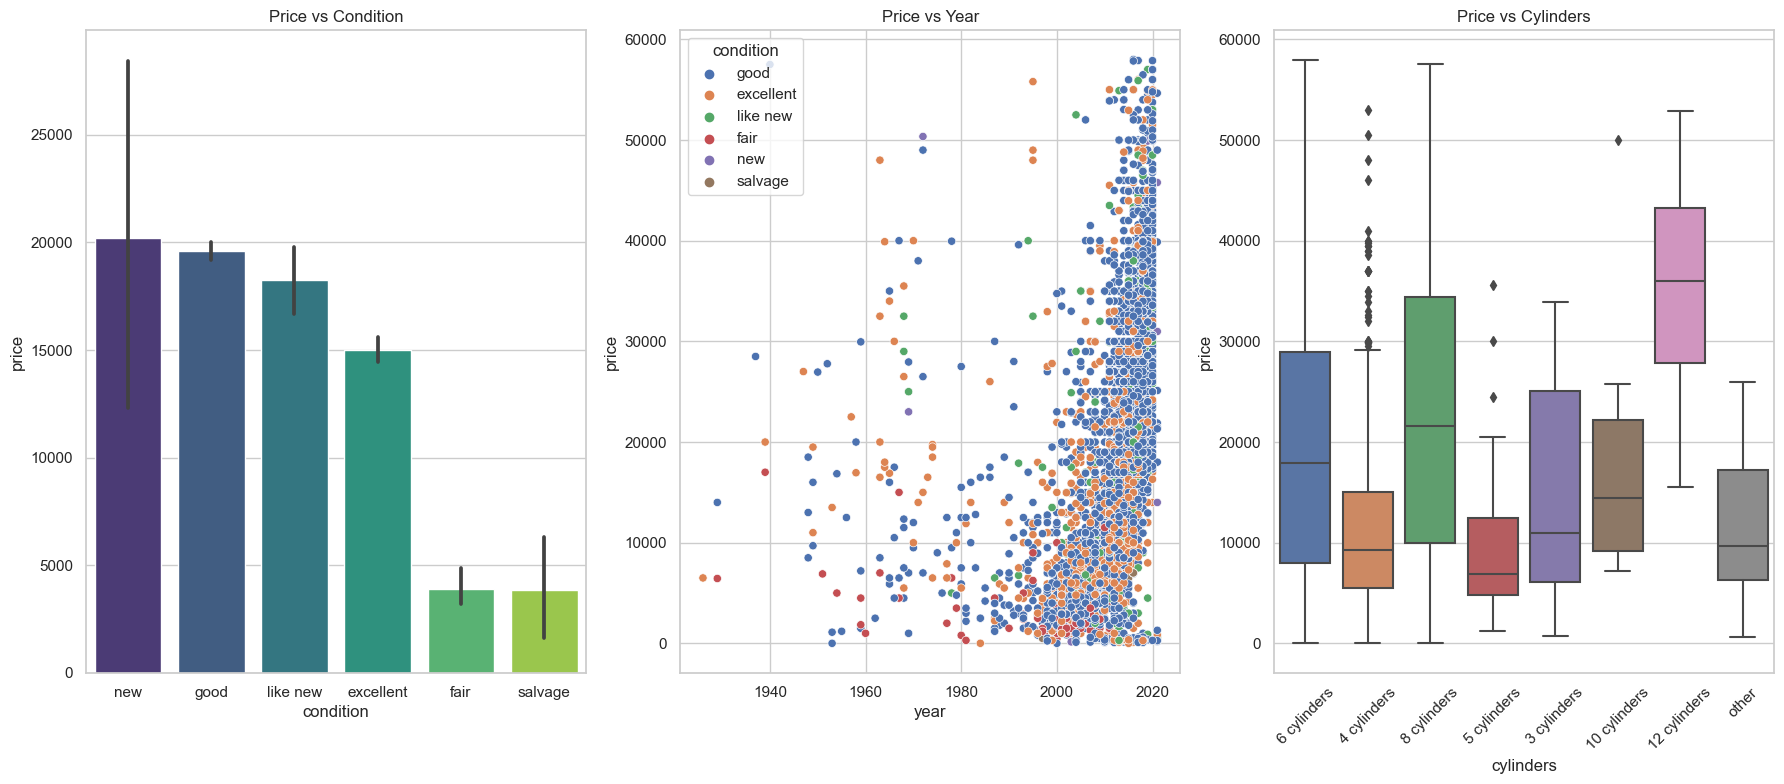

In [500]:
df_sorted = cars.sort_values(by=['price'])
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
sns.barplot(x='condition', y='price', data=df_sorted.sample(5000),
            order=df_sorted.groupby('condition')['price'].median().sort_values(ascending=False).index, ax=axes[0], palette='viridis')
axes[0].set_title('Price vs Condition')
sns.scatterplot(x='year', y='price', data=cars.sample(5000), ax=axes[1], color='blue', hue='condition')
axes[1].set_title('Price vs Year')
sns.boxplot(x='cylinders', y='price', data=cars.sample(5000), ax=axes[2])
axes[2].set_title('Price vs Cylinders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations from above graph**

In a sample size of 5000, it is noticeable that car prices demonstrate a correlation with both condition and year. As anticipated, newer vehicles, particularly those in new or good condition, tend to command higher prices compared to fair and salvage vehicles.


**Convert Non-numeric data to numeric data using Label Encoding**

To enable the use of non-numeric data, such as cylinders, region, manufacturer, model, etc., for correlation analysis and pair plot visualization, a conversion to numeric data is necessary. 

Label encoding has been selected for this purpose. It's important to note that label encoding is suitable for categorical columns. However, caution is advised when applying label encoding to non-categorical columns, as it may introduce a false sense of order or hierarchy that isn't inherent in the original data. This could potentially mislead machine learning algorithms.

In [501]:
categorical_columns = cars.select_dtypes(include=['object']).columns

# Apply Label Encoding to only categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    cars[col] = label_encoders[col].fit_transform(cars[col])

print(cars)
# Decode the categorical columns back
# for col in categorical_columns:
#     cars[col + '_decoded'] = label_encoders[col].inverse_transform(cars[col])

# Display the DataFrame after label encoding and decoding
# print(cars)

        region  price    year  manufacturer  model  condition  cylinders  \
27          16  33590  2014.0            14  21355          2          6   
28          16  22590  2010.0             7  21667          2          6   
29          16  39590  2020.0             7  21691          2          6   
30          16  30990  2017.0            38  24366          2          6   
31          16  15000  2013.0            13  12687          0          5   
...        ...    ...     ...           ...    ...        ...        ...   
426875     397  23590  2019.0            30  17302          2          5   
426876     397  30590  2020.0            40  20734          2          5   
426877     397  34990  2020.0             6  25671          2          5   
426878     397  28990  2018.0            23  11812          2          5   
426879     397  30590  2019.0             4   2693          2          5   

        fuel  odometer  title_status  transmission  drive  type  paint_color  \
27     

In [502]:
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
Index: 325741 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        325741 non-null  int32  
 1   price         325741 non-null  int64  
 2   year          325741 non-null  float64
 3   manufacturer  325741 non-null  int32  
 4   model         325741 non-null  int32  
 5   condition     325741 non-null  int32  
 6   cylinders     325741 non-null  int32  
 7   fuel          325741 non-null  int32  
 8   odometer      325741 non-null  float64
 9   title_status  325741 non-null  int32  
 10  transmission  325741 non-null  int32  
 11  drive         325741 non-null  int32  
 12  type          325741 non-null  int32  
 13  paint_color   325741 non-null  int32  
 14  state         325741 non-null  int32  
dtypes: float64(2), int32(12), int64(1)
memory usage: 24.9 MB
None


In [503]:
# labelEncoder.inverse_transform([14]) # here since label encoder is only persisting the last column, inverse transforming will return the state name for the encoded value.

**Encoding Notes**

After using Label Encoding from SK Learn, we could see that all the above data is now transformed into numeric data. It can be observed from the data type of each column that all are int32 or int64 indicating that they are all numeric.

#### Correlation Matrix and Heat maps


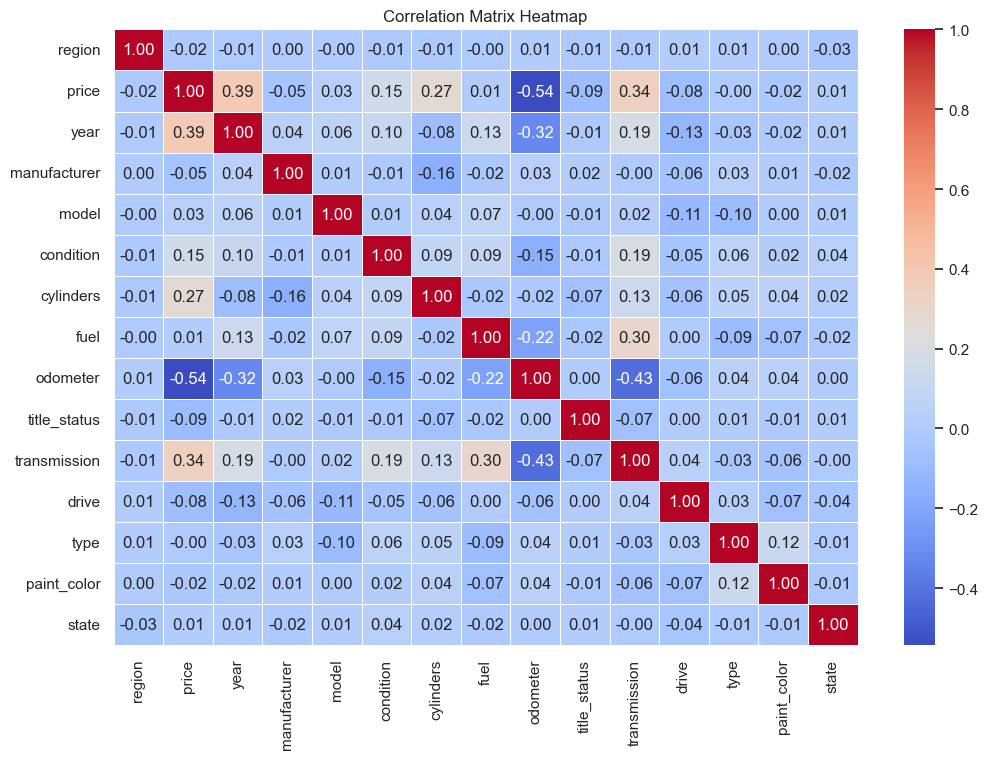

In [504]:
correlation_matrix = cars.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Correlation Matrix Notes:**
From the above matrix, we can observe that the odometer, transmission and year have higher correlation to price compared to other features as expected.

***
### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [505]:
# Original Data
X = cars.drop('price', axis=1) # dropping price since that is our target.
y = cars['price'] # Setting prices as target.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linReg = LinearRegression(fit_intercept=False).fit(X_train, y_train)

print(linReg.score(X_train, y_train))
print(linReg.score(X_test, y_test))
print("mse = ", mean_squared_error(y_test, linReg.predict(X_test)))


0.41177603523312545
0.4089527341062772
mse =  96460168.11029527


#### PCA Analysis

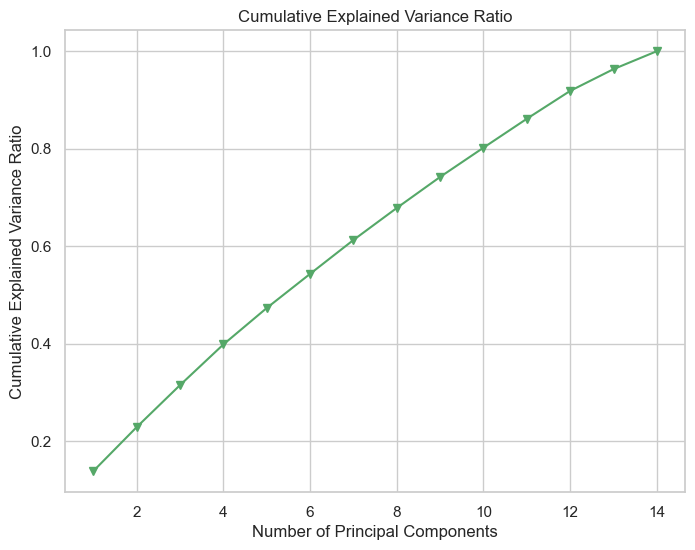

In [506]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1),
         cumulative_variance_ratio, marker='v', linestyle='-', color='g')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

In [507]:
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
print(X_train.shape)


(260592, 14)


### Modeling with various regression techniques.

Here, I'm using Linear regression, ridge regression, LASSO regression and random forest regression for this modeling.

                     Model           MSE          MAE        R2
0        Linear Regression  8.849455e+07  7034.880759  0.457761
1  Linear Regression (PCA)  8.849455e+07  7034.880759  0.457761
2                    Ridge  8.849454e+07  7034.881534  0.457761
3              Ridge (PCA)  8.849450e+07  7034.888522  0.457761
4                    Lasso  8.849424e+07  7034.903185  0.457763
5              Lasso (PCA)  8.849452e+07  7034.884462  0.457761
6            Random Forest  2.158952e+07  2401.414801  0.867713
7      Random Forest (PCA)  3.313229e+07  3458.814205  0.796986


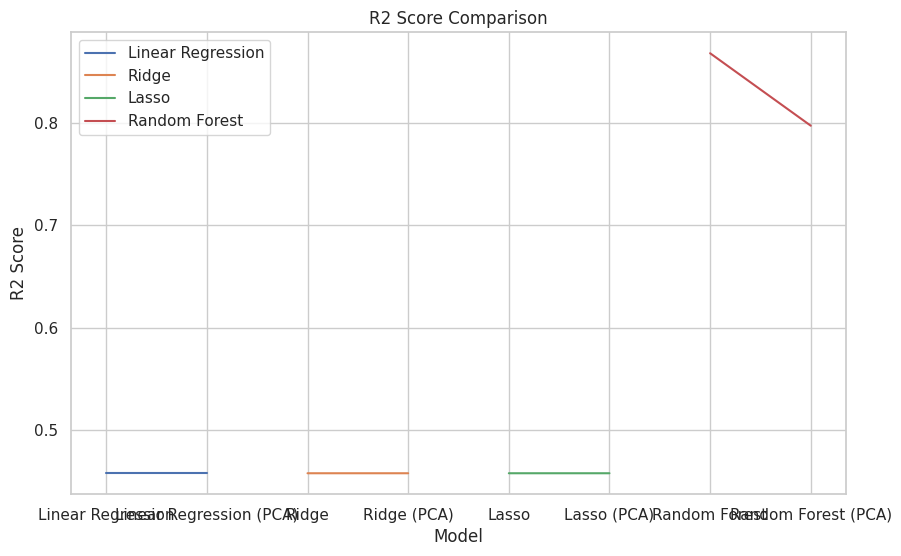

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor()
}

# Define parameter grids for grid search
param_grids = {
    'Linear Regression': {},
    'Ridge': {'alpha': [0.1, 1, 10]},
    'Lasso': {'alpha': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [50]}
}

# Initialize results dictionary
results = {'Model': [], 'MSE': [], 'MAE': [], 'R2': []}

# Perform modeling and grid search
for model_name, model in models.items():
    # Standardized data without PCA
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results['Model'].append(model_name)
    results['MSE'].append(mse)
    results['MAE'].append(mae)
    results['R2'].append(r2)

    # Standardized data with PCA
    model_pca = GridSearchCV(model, param_grids[model_name], cv=5)
    model_pca.fit(X_train_pca, y_train)
    y_pred_pca = model_pca.predict(X_test_pca)
    mse_pca = mean_squared_error(y_test, y_pred_pca)
    mae_pca = mean_absolute_error(y_test, y_pred_pca)
    r2_pca = r2_score(y_test, y_pred_pca)
    results['Model'].append(model_name + ' (PCA)')
    results['MSE'].append(mse_pca)
    results['MAE'].append(mae_pca)
    results['R2'].append(r2_pca)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

                     Model           MSE          MAE        R2
0        Linear Regression  5.860436e+07  5574.711791  0.604031
1  Linear Regression (PCA)  5.860436e+07  5574.711791  0.604031
2                    Ridge  5.860438e+07  5574.713294  0.604031
3              Ridge (PCA)  5.860456e+07  5574.726844  0.604029
4                    Lasso  5.860456e+07  5574.729876  0.604029
5              Lasso (PCA)  5.860443e+07  5574.717124  0.604030
6            Random Forest  1.449205e+07  2149.187620  0.902082
7      Random Forest (PCA)  2.244594e+07  2985.534702  0.848341


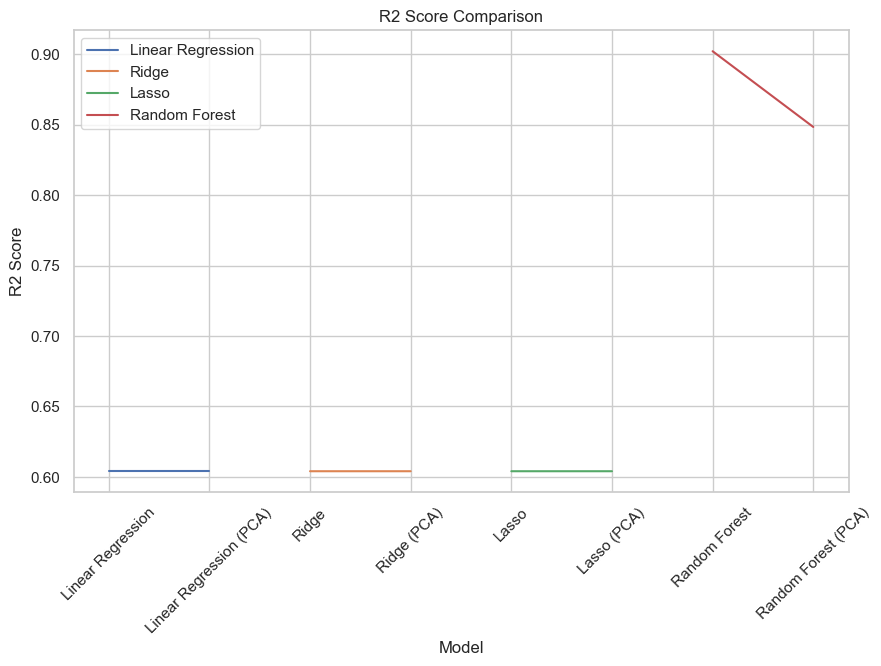

In [433]:
# Display results
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
for model_name in models.keys():
    plt.plot(
        results_df[results_df['Model'].str.contains(model_name)]['Model'],
        results_df[results_df['Model'].str.contains(model_name)]['R2'],
        label=model_name
    )

plt.title('R2 Score Comparison')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

After training with various regression techniques, the Random Forest Regression method yielded the most favorable results, achieving approximately 90% accuracy. Surprisingly, the application of Principal Component Analysis (PCA) did not enhance the model's performance compared to the model trained without PCA analysis.

Utilizing the RandomForest model, a graphical representation comparing actual and predicted results for a sample of 20 data points from the test set is presented below.

        Actual     Predicted
89385     8500  13905.940000
316175    6990   5583.330000
268856   26995  26995.000000
306763   24590  24590.000000
111700    4950   6968.680000
280797    7000  25780.940000
254768   13995  15477.730000
319599    7999   7736.500000
212681   19990  20825.800000
164915   12995  12233.520000
181363   30990  31030.050000
99136    40000  33130.090000
219587    6950   6593.560000
250168    6500   6704.940000
15327     8500   7893.693333
79709     8000   4749.530000
229775    7150   7697.516667
187827    7500   8938.370000
132100   10450  11525.170000
2709     10400  19711.450000


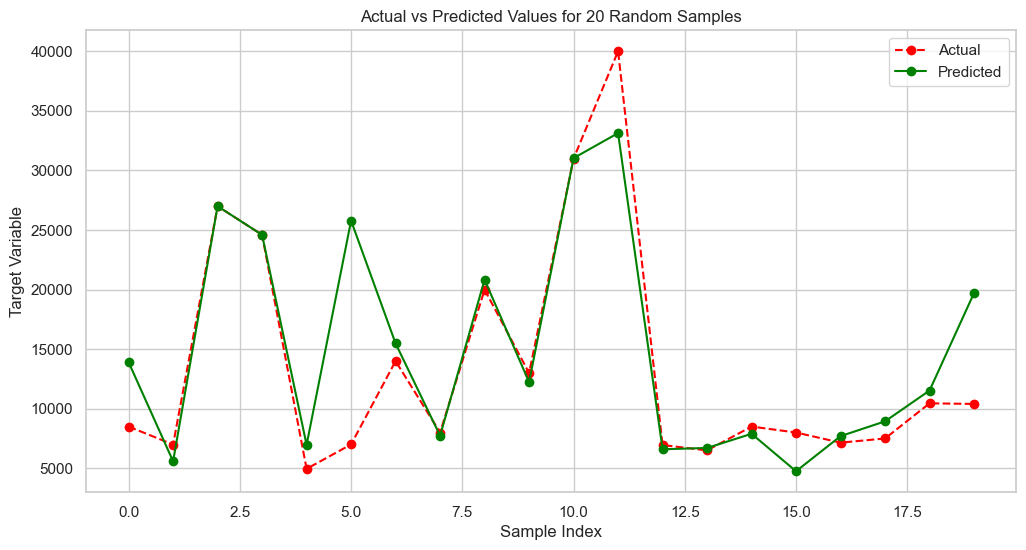

In [437]:
rf_model = models['Random Forest']

# Generate 20 random indices for samples
num_samples = 20
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
X_sample = X_test.iloc[random_indices]

# Standardize and apply PCA if necessary
X_sample_scaled = scaler.transform(X_sample)
X_sample_pca = pca.transform(X_sample_scaled)

# Predict outputs
y_pred_sample = rf_model.predict(X_sample_scaled)

# Create a DataFrame with actual and predicted values
sample_results = pd.DataFrame({
    'Actual': y_test.iloc[random_indices],
    'Predicted': y_pred_sample
})

# Display the actual vs predicted values
print(sample_results)

# Visualize the results in a line graph
plt.figure(figsize=(12, 6))
plt.plot(range(num_samples), sample_results['Actual'], label='Actual', marker='o', linestyle='--', c='red')
plt.plot(range(num_samples), sample_results['Predicted'], label='Predicted', marker='o', c='green')
plt.title('Actual vs Predicted Values for 20 Random Samples')
plt.xlabel('Sample Index')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

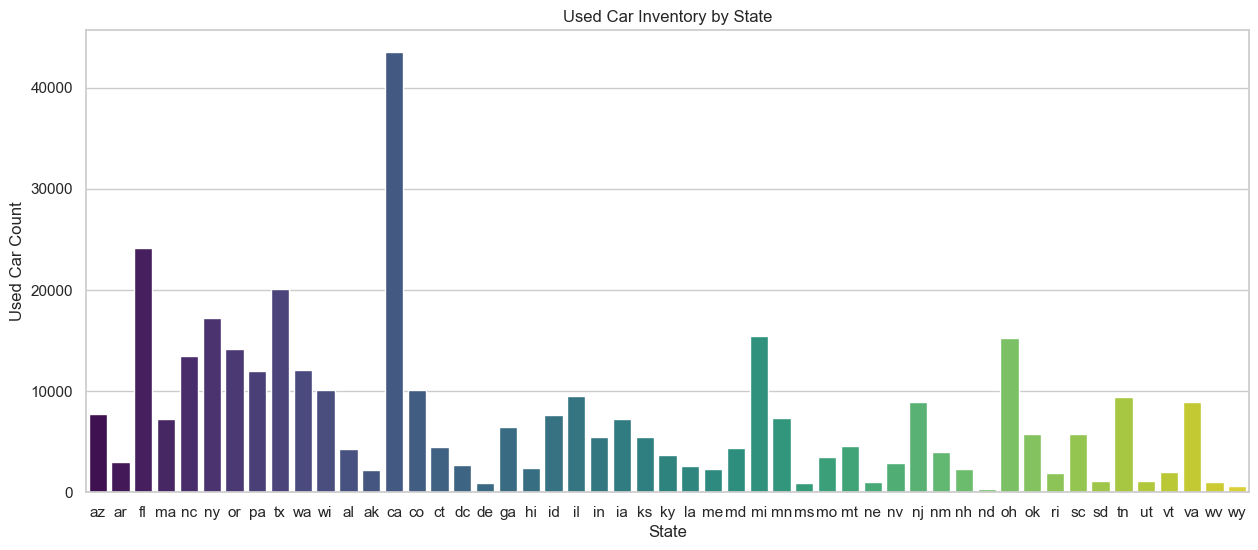

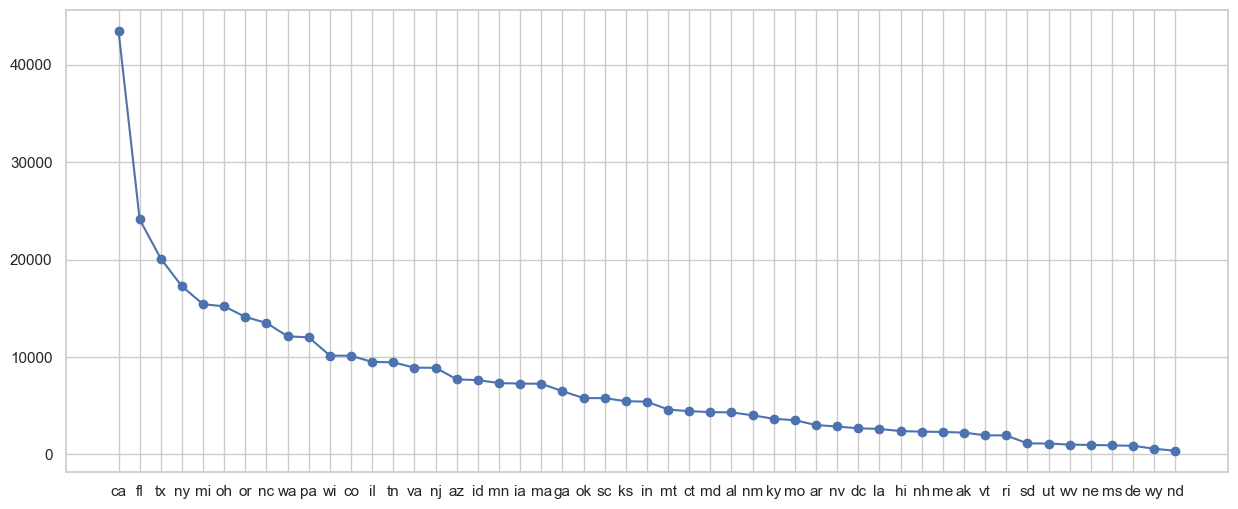

In [421]:
plt.figure(figsize=(15, 6))
sns.countplot(x='state', data=carsOriginal, palette='viridis')

plt.title('Used Car Inventory by State')
plt.xlabel('State')
plt.ylabel('Used Car Count')

# Drawing a line graph based on the counts
state_counts = carsOriginal['state'].value_counts()
plt.figure(figsize=(15, 6))
plt.plot(state_counts.index, state_counts.values, marker='o', linestyle='-', color='b')

Text(0, 0.5, 'Used Car Count')

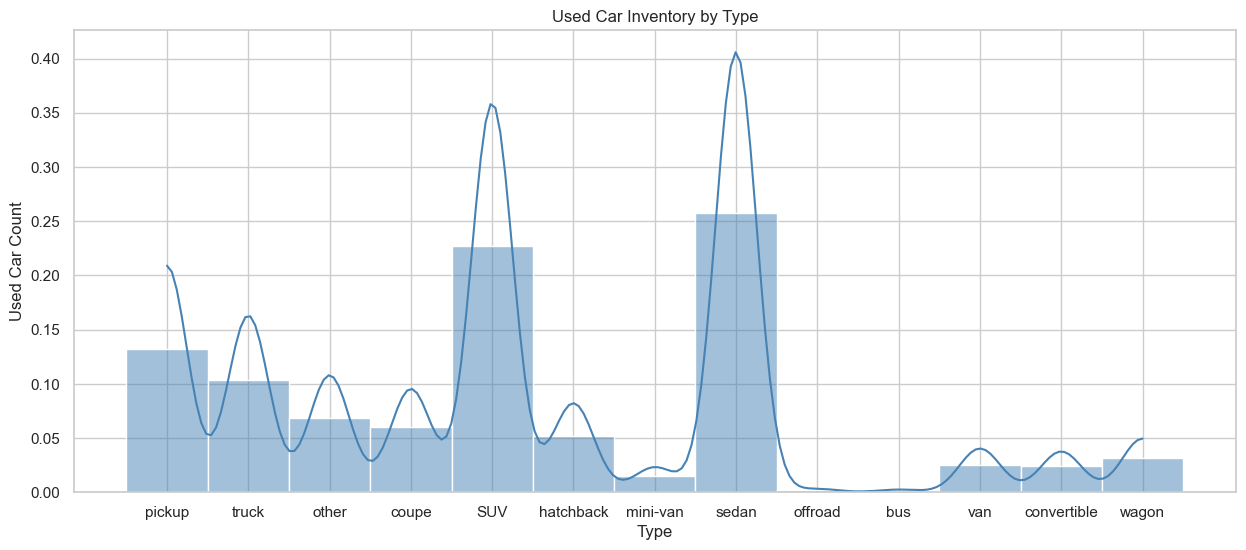

In [426]:
plt.figure(figsize=(15, 6))
sns.histplot(x='type', data=carsOriginal, stat='density', color='steelblue', kde=True)


plt.title('Used Car Inventory by Type')
plt.xlabel('Type')
plt.ylabel('Used Car Count')

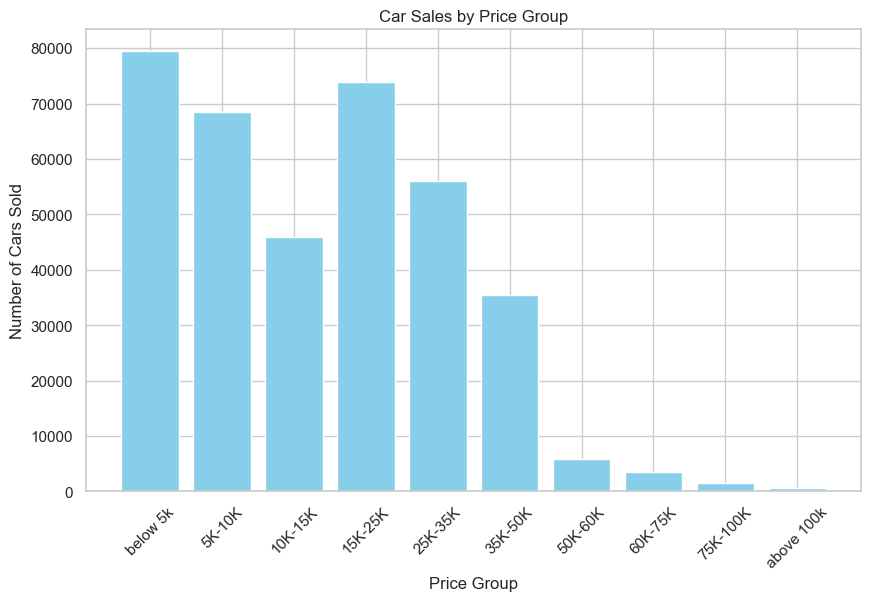

In [431]:
price_bins = [0, 5000, 10000, 15000, 25000, 35000, 50000, 60000, 75000, 100000, 5000000]
price_labels = ['below 5k', '5K-10K', '10K-15K','15K-25K', '25K-35K','35K-50K', '50K-60K', '60K-75K', '75K-100K', 'above 100k']

# Cut the data into price groups
carsOriginal['Price Group'] = pd.cut(carsOriginal['price'], bins=price_bins, labels=price_labels, right=False)

# Count car sales in each price group
sales_by_price_group = carsOriginal['Price Group'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sales_by_price_group.index, sales_by_price_group.values, color='skyblue')
plt.title('Car Sales by Price Group')
plt.xticks(rotation=45)
plt.xlabel('Price Group')
plt.ylabel('Number of Cars Sold')
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Dear Client,

I am pleased to present the findings and recommendations based on our analysis of the used car market. 

Our goal was to provide insights that can help fine-tune your inventory and enhance decision-making processes. Below, I've summarized our primary findings and recommendations:

### 1. Market Overview:
#### a. Most Popular Car Brands:

- Identified the most popular car brand to be **_Ford_** followed by **_Chevrolet_** based on the dataset.
- __Recommendation:__ Consider increasing the stock of these popular brands to meet customer demand.

#### b. Pricing Trends:

- Analyzed pricing trends for different car segments.
- Identified a price range of **_below 5K_**, followed by cars pricing up to **_25K_** are the most sold cars.
- __Recommendation:__ Adjust inventory to align with the pricing preferences of potential buyers.

#### c. Model Trends:

- Analyzed model trends over the years 
- Identified that **_Sedans_** are the most sold cars followed by **_SUVs_**.
- __Recommendation:__ Adjust inventory to attact potential buyers of sedans and SUVs.

#### d. Most Used Cars Sold States:

- Analyzed and identified that most cars are sold in **_California_**, followed by **_Florida_** and then by **_Texas_** and so on.

### 2. Predictive Modeling:
#### a. Regression Models:
- Applied various regression techniques to predict car prices.
- Utilized techniques such as Principal Component Analysis and Grid Search for model optimization.
- Obtained metrics (MSE, MAE, R2) for evaluation of each model.
- Identified key features influencing car prices. 

#### b. Random Sample Predictions:
- Randomly sampled inputs and predicted outputs using the Random Forest Regressor.
- Visualized the actual vs. predicted values for a more practical understanding.
- Identified areas for potential pricing adjustments.

### 3. Categorical Data Handling:
#### a. Label Encoding:
- Applied Label Encoding to categorical features for modeling purposes.
- Ensured accurate representation of categorical data in predictive models.
- Recommended continuous monitoring for model performance.

### Recommendations:

##### a. Inventory Adjustment:

- Based on popular brands and pricing trends, consider adjusting the inventory to include more of the sought-after brands and align with the preferred price ranges.

##### b. Dynamic Pricing:

- Implement a dynamic pricing strategy based on predictive modeling results.
- Regularly update prices based on market demand and competition.

##### c. Customer Preferences:

- Leverage insights from regression models to understand the features influencing prices.
- Align inventory with customer preferences by highlighting or offering more vehicles with desirable features.

##### d. Continuous Monitoring:

- Continuously monitor the performance of the predictive models.
- Regularly update models to adapt to changing market conditions.

In conclusion, the insights provided aim to enhance your decision-making process and optimize your used car inventory to meet customer preferences effectively. Feel free to reach out if you have any questions or if you would like further clarification on any aspect of our analysis.

Thank you for entrusting us with this project. We look forward to assisting you in achieving greater success in the used car market.

Sincerely,

Abhinav. 

### Steps for Deploying a Machine Learning Model to a Website:

1. **Save the Model:** Save the trained model using a format like Pickle or joblib.
2. **Set Up a Web Application:** Create a web application using a framework like Flask, Django, or FastAPI. Set up routes and views for handling HTTP requests.
3. **Create an HTML Form:** Design a web form to take input features from users (e.g., car features for prediction).
4. **Handle Predictions in the Web App:** In your web application, create a route to handle the form submissions. Extract input features from the form, preprocess them, and use the saved model for predictions.
5. **Display Prediction Results:** Create an HTML template to display the prediction results.
6. **Deploy the Web Application:** Deploy your web application using a platform like Heroku, AWS, or any other suitable hosting service.

